[*********************100%***********************]  1 of 1 completed
Text Metrics:
duration: (35.0, 105.0, 58.22222222222222, 42.0, 27.22947749121243)
total_return: 115.52870558219888
buy_and_hold_performance: 42.767174990960854
volatility: 1.8097131668812396
maximum_drawdown: 0.15091122705875915
win_loss_ratio: 3.5


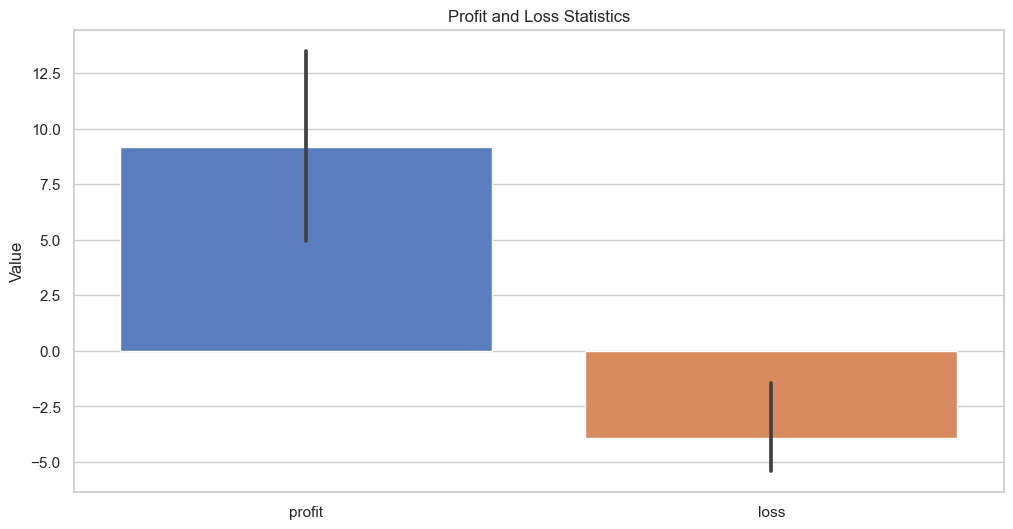

[*********************100%***********************]  1 of 1 completed


Text Metrics:
duration: (10.0, 202.0, 88.16666666666667, 84.0, 71.03637565829683)
total_return: -10.016882684329735
buy_and_hold_performance: 42.767174990960854
volatility: 1.233975830753901
maximum_drawdown: 0.08497085689071715
win_loss_ratio: 2.0


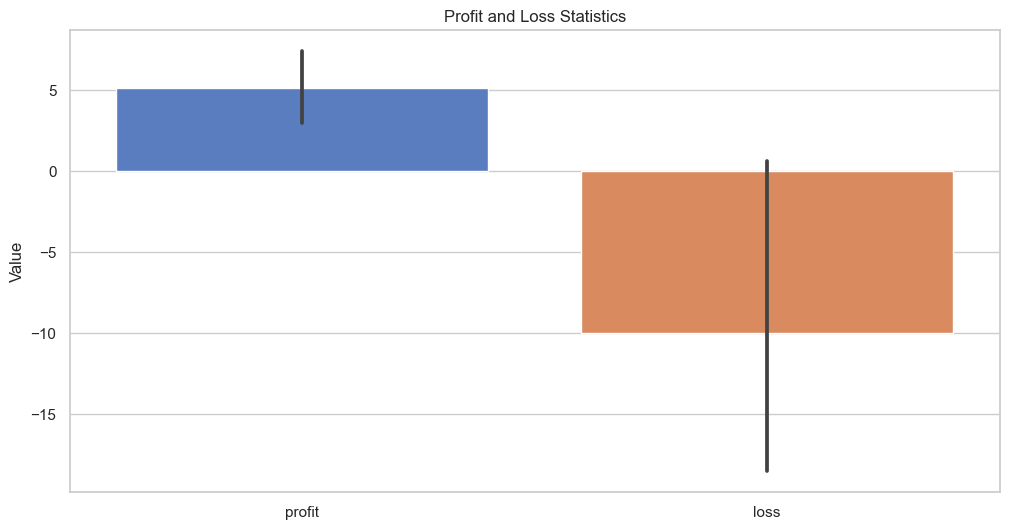

[*********************100%***********************]  1 of 1 completed


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import yfinance as yf
from machine_learning_finance import analyze_trades, generate_probability, attach_markers, \
    calc_durations_with_extremes, plot_full_analysis, prob_chart
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
windows = [300, 600, 900, 1500]

# todo because the inverse strategy is long and long inverse it doesn't render correctl
# we should hack to render as short or render a second time series
file = "../backtests/backtest_inverse_XLE_365_h0.9_l0.1.csv"
symbol = "XLE"
period = 365


def analyze_and_graph(file, symbol, period):

    ledger = pd.read_csv(file)
    metrics = analyze_trades(ledger, symbol, period)

    # Set the style for the plots
    sns.set(style='whitegrid')

    # Display metrics as text
    print("Text Metrics:")
    for key, value in metrics.items():
        if key not in ['profit_stats', 'loss_stats']:
            print(f"{key}: {value}")

    # Create a bar plot for profit and loss stats
    profit_stats, loss_stats = metrics['profit_stats'], metrics['loss_stats']
    profit_loss_df = pd.DataFrame([profit_stats, loss_stats], columns=['min', 'max', 'mean', 'median', 'std'], index=['profit', 'loss'])

    plt.figure(figsize=(12, 6))
    ax = sns.barplot(data=profit_loss_df.transpose(), palette='muted')
    ax.set_title('Profit and Loss Statistics')
    ax.set_ylabel('Value')

    # Show the plot
    plt.show()

    tickerObj = yf.download(tickers=symbol, interval="1d")
    df_raw = pd.DataFrame(tickerObj)
    df_raw = df_raw.tail(period)


    trend, prob_above_trend, prob_below_trend, volatility, model = generate_probability(df_raw)
    df_raw = attach_markers(df_raw, trend, prob_above_trend)
    df_durations = calc_durations_with_extremes(df_raw)
    plot_full_analysis(df_raw, trend, prob_above_trend, prob_below_trend, model, df_durations, ledger)
    pd.options.display.max_rows = None


analyze_and_graph("../backtests/backtest_inverse_XLE_365_h0.8_l0.2.csv", "XLE", 365)    
analyze_and_graph("../backtests/backtest_inverse_XLE_730_h0.8_l0.2.csv", "XLE", 365)
    